## Problemas

### Dados faltantes

Analisando o conjunto de treinamento, notamos que há dados faltando nas colunas 'Cabin', 'Age' e 'Embarked', 77%, 20% e 0.2%, respectivamente. Em geral, é aconselhado remover a coluna com dados faltantes acima de 30%, entretanto não há uma resposta exata para como deve-se lidar com colunas nesta situação. Neste caso, pela quantidade de dados faltantes foi preferível remover a coluna 'Cabin'.

### Classes desbalanceadas

Dentro desta analise rapida, observou-se que há um desbalanceamento das classes 'male' e 'female', 0 e 1, respectivamente.

## Bibliotecas

In [51]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegressionCV

from sklearn.inspection import permutation_importance

from sklearn.metrics import fbeta_score, make_scorer

from skopt import BayesSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dado_treino = pd.read_csv('train.csv')
dado_teste = pd.read_csv('test.csv')

In [113]:
dado_treino

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Dados treino

In [85]:
dado_treino['Survived'].value_counts()/891

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [11]:
dado_treino.isna().sum().sort_values(ascending=False)/891

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

In [3]:
dado_treino.drop(labels='Cabin', axis=1, inplace=True)

In [115]:
dado_treino[['Age', 'Embarked']].dtypes

Age         float64
Embarked     object
dtype: object

In [15]:
dado_treino.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [4]:
dado_treino.replace(['S', 'C', 'Q'], [1.0, 2.0, 3.0], inplace=True)

In [5]:
dado_treino.replace(['male', 'female'], [0, 1], inplace=True)

- Sem 'name' e 'ticket'

In [6]:
dado_treino.drop(labels=['Name', 'Ticket'], inplace=True, axis=1)

## Dados teste

In [87]:
dado_teste

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [88]:
dado_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
dado_teste.drop(labels=['Cabin'], inplace=True, axis=1)

In [8]:
dado_teste.drop(labels=['Name', 'Ticket'], inplace=True, axis=1)

In [9]:
dado_teste.replace(['male', 'female'], [0, 1], inplace=True)
dado_teste.replace(['S', 'C', 'Q'], [1.0, 2.0, 3.0], inplace=True)

In [10]:
dado_teste.shape

(418, 8)

## Fatiando em treino e teste

In [10]:
registros_nan = dado_treino.isna().apply(lambda x: x.sum(), axis=1) > 0

dados_nan = dado_treino[registros_nan]
dados_originais = dado_treino[~registros_nan]

In [11]:
lista = dado_treino.columns.to_list()
lista.remove('Survived')

In [12]:
X_treino, X_teste, y_treino, y_teste = train_test_split(dados_originais[lista], dados_originais['Survived'], test_size=0.3)

In [13]:
X_treino.shape, y_treino.shape, X_teste.shape, y_teste.shape

((498, 8), (498,), (214, 8), (214,))

In [14]:
X_treino_completo = pd.concat([X_treino, dados_nan[lista]], axis=0)
y_treino_completo = pd.concat([y_treino, dados_nan['Survived']], axis=0)

In [127]:
y_treino_completo.shape, X_treino_completo.shape

((677,), (677, 8))

In [23]:
dado_treino

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,1.0
1,2,1,1,1,38.0,1,0,71.2833,2.0
2,3,1,3,1,26.0,0,0,7.9250,1.0
3,4,1,1,1,35.0,1,0,53.1000,1.0
4,5,0,3,0,35.0,0,0,8.0500,1.0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,1.0
887,888,1,1,1,19.0,0,0,30.0000,1.0
888,889,0,3,1,NaN,1,2,23.4500,1.0
889,890,1,1,0,26.0,0,0,30.0000,2.0


## Tratando os valores ausentes

In [15]:
imputador = IterativeImputer(
    max_iter=30,
    min_value=0,
    initial_strategy='median',
    random_state=1,
    n_nearest_features=7
).fit(X_treino_completo, y_treino_completo)

In [16]:
meu_array = imputador.fit_transform(X_treino_completo)

In [17]:
dados_preenchidos = pd.DataFrame(meu_array, columns=X_treino_completo.columns, index=X_treino_completo.index)

In [18]:
meu_array_teste = imputador.fit_transform(dado_teste)

In [19]:
dados_preenchidos_teste = pd.DataFrame(meu_array_teste, columns=dado_teste.columns, index=dado_teste.index)

## Modelo

- Otimizando hiperparâmetros

In [52]:
parametros = {
    'Cs':[1, 5, 15, 20],
    'cv':[5, 10],
    'max_iter':[30, 100, 200],
    'solver':['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky'],
    'n_jobs':[4, -1],
    'penalty':['l1', 'l2', 'elasticnet']
}

In [62]:
nbeta = make_scorer(fbeta_score, beta=0.001)

rs = RandomizedSearchCV(
    estimator=LogisticRegressionCV(),
    param_distributions=parametros,
    random_state=1,
    n_iter= 576,
    scoring= 'f1' #nbeta
).fit(dados_preenchidos, y_treino_completo)

c:\Users\jeffe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\jeffe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jeffe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1789, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\jeffe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\Users\jeffe\anaconda3\lib\site-packages\sklearn\model_selection\_v

In [ ]:
# bs = BayesSearchCV(
#     estimator=LogisticRegressionCV(),
#     search_spaces=parametros,
#     scoring='f1',
#     random_state=1,
#     n_iter=576
# ).fit(dados_preenchidos, y_treino_completo)

In [ ]:
# bs.best_params_

In [63]:
rs.best_params_

{'solver': 'lbfgs',
 'penalty': 'l2',
 'n_jobs': 4,
 'max_iter': 100,
 'cv': 10,
 'Cs': 5}

- Gerando modelo

In [64]:
modelo = LogisticRegressionCV(
    Cs=5,
    max_iter=100,
    solver='lbfgs',
    random_state=1,
    n_jobs=4,
    cv=10,
    penalty='l2'
)

- Treinando modelo

In [65]:
modelo.fit(dados_preenchidos, y_treino_completo)

LogisticRegressionCV(Cs=5, cv=10, n_jobs=4, random_state=1)

- Avaliando acurácia

In [66]:
modelo.score(X_teste, y_teste)

0.794392523364486

- Matriz de confusão

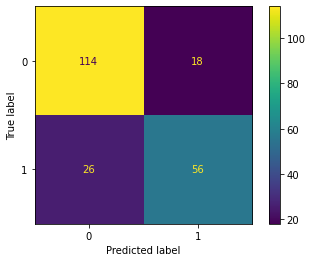

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


predictions = modelo.predict(X_teste)
cm = confusion_matrix(y_teste, predictions, labels=modelo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=modelo.classes_)
disp.plot()
plt.show()

- Feature importance

In [69]:
importance = permutation_importance(
    estimator=modelo,
    X=X_teste,
    y=y_teste,
    scoring= 'f1', #nbeta, #'f1',
    n_repeats=20,
    random_state=1
                                    )

In [70]:
array_permutation = importance.importances_mean

indices_ordenados = np.argsort(array_permutation)[::-1]

for i in range(X_teste.shape[1]):
    print(f'{X_teste.columns[indices_ordenados[i]]}: {array_permutation[indices_ordenados[i]]}')

Sex: 0.24128234094335604
Pclass: 0.08309963166072099
Age: 0.018120894806333304
SibSp: 0.01551510460482462
Parch: 0.007980064589885877
Embarked: 0.005086856161440162
Fare: 0.004677426881043128
PassengerId: -0.0009263854425144435


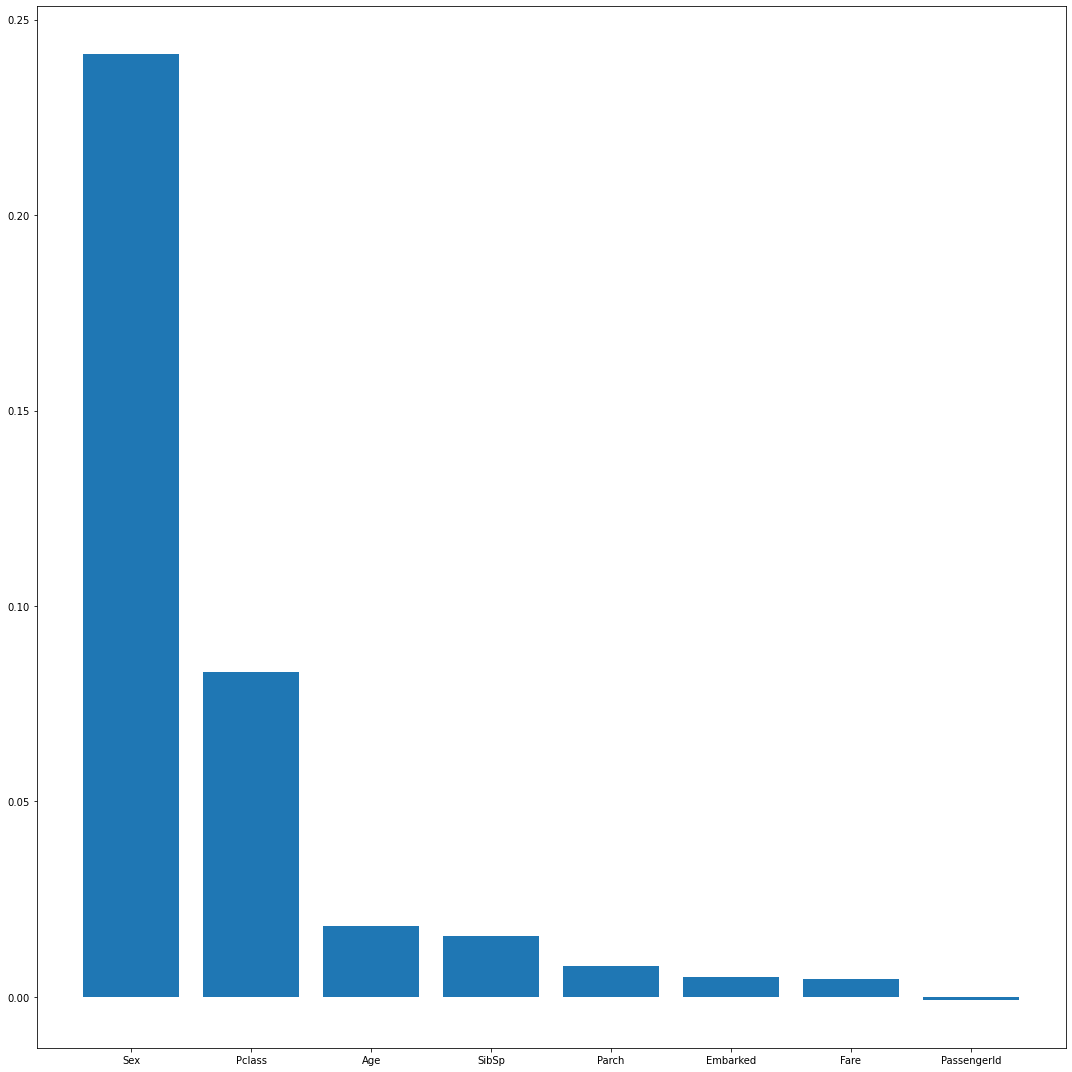

In [71]:
plt.figure(figsize=(15, 15))
plt.bar(range(X_teste.shape[1]), array_permutation[indices_ordenados], align='center')
plt.xticks(range(X_teste.shape[1]), dados_preenchidos.columns[indices_ordenados])
# plt.savefig('Feature_importance.jpeg')
plt.tight_layout()
plt.show()

## Gerando o arquivo submission

In [143]:
submission = modelo.predict(dados_preenchidos_teste)

In [144]:
submission

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [148]:
submission = pd.DataFrame(submission, columns=['Survived'], index=dado_teste.index)

In [155]:
p = pd.concat([dado_teste['PassengerId'], submission], axis=1).to_csv('titanic_submission.csv', index=False)

In [158]:
ver = pd.read_csv('titanic_submission.csv')

In [159]:
ver

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [160]:
vers = pd.read_csv('gender_submission.csv')
vers

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Próximos passos

> - Analisar as variáveis relevantes por meio de uma feature importance
> - alterar o probability threshold do modelo 
> - Balancear as classes por meio do ROS, ROSE, SMOTE e variações